## Nome: Fabio Grassiotto
## RA: 890441
## Disciplina: IA369Y, 2º S 2017
## T3 - Análise e Síntese de Emoções em Conteúdo Multimídia
## Atividade 5 - Classificador de emoções para base de fotos rotulada.

## 1. Objetivo

O objetivo desta atividade é implementar um classificador de emoções utilizando marcos faciais para uma base de fotos rotulada. A base contém fotos do rosto de uma atriz e um arquivo csv com o nome do arquivo, rótulo emocional e 56 pares de coordenadas no formato (x;y) mapeando os marcos faciais em cada uma das fotos.

Para executar a classificação, 80% da base será utilizada como conjunto de treinamento enquanto que os 20% restantes serão classificados utilizando a biblioteca scikit-learn (Pedregosa et al., 2011). A acurácia do classificador será relatada em comparação com os rótulos fornecidos.

## 2. Leitura da base de dados

O primeiro passo consistirá na leitura do corpus fornecido. O arquivo CSV foi analisado, notando-se que as colunas de índice 1-8 não contém informações relevantes para a classificação e portanto poderiam ser descartadas.
O carrregamento dos dados foi realizada utilizando a biblioteca Pandas, excluindo os dados desnecessários, conforme o script a seguir.


In [1]:
import pandas as pd
import numpy as np

def read_csv():
    "Leitura das colunas: nome do arquivo, rótulo, 56 colunas de coordenadas."
    all_cols = list(range(0,65))
    remove_cols = set(range(2,9))
    cols = [col for col in all_cols if col not in remove_cols]
    return pd.read_csv('Faces_Disciplina\imagedb_CH_disciplina.csv', header=None, usecols=cols)

df = read_csv()

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 6)

df

,0,1,9,...,62,63,64
0,Em9_Fala3_0204_640x480.png,admiration,(303.5;319.0),...,(344.0;338.0),(363.5;325.5),(363.5;333.0)
...,...,...,...,...,...,...,...
896,Em16_Fala3_0180_640x480.png,shame,(285.5;328.0),...,(315.0;332.5),(328.0;328.5),(328.0;331.0)


## 3. Análise dos dados de entrada

Ao analisar os dados de entrada, foi verificada a quantidade de rótulos emocionais aplicada aos marcos faciais de cada amostra:

In [2]:
df[1].unique()

array(['admiration', 'anger', 'disapointment', 'disgust', 'fear',
       'fearsconfirmed', 'gloating', 'gratification', 'gratitude',
       'happyfor', 'hope', 'joy', 'love', 'neutral', 'pity', 'pride',
       'relief', 'remorse', 'reproach', 'ressentment', 'sadness',
       'satisfaction', 'shame'], dtype=object)

Na planilha de entrada, existem 23 rótulos emocionais para as 896 amostras fornecidas.
A planilha ainda fornece marcos faciais para cada uma das amostras, que foram plotadas nos gráficos abaixo.

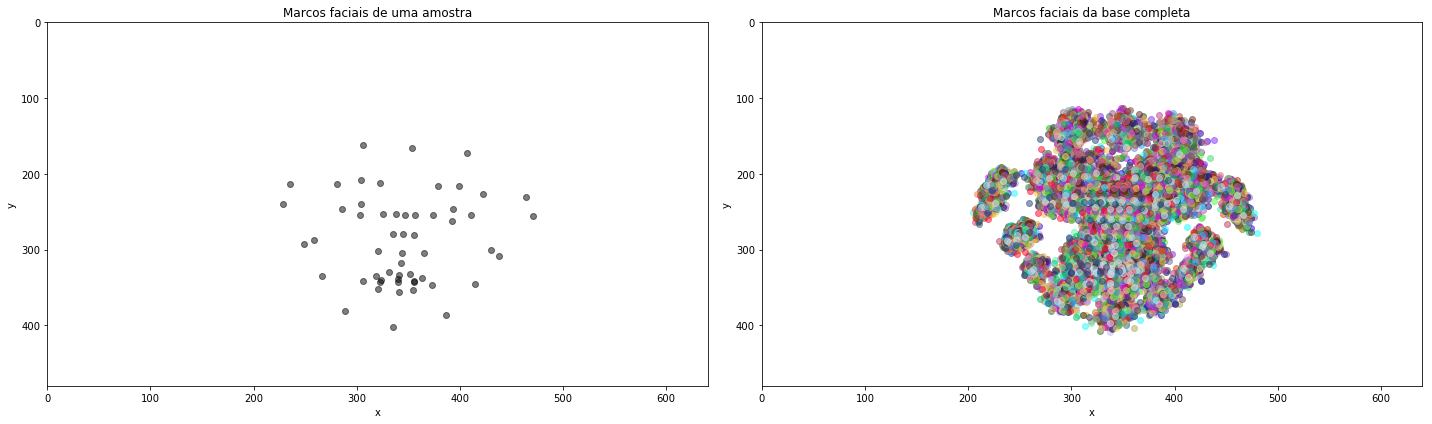

In [3]:
# Atividade 5 - Disciplina IA369Y 2S 2017
# Classificador de emoções para base de fotos rotulada.
# Este arquivo executa exploração dos dados de entrada usando matplotlib.
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from random import randint

matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)

# Para reformatar coordenadas.
def get_coord(x):
    x = x.strip('()')
    return x.split(";")

# Definição de subplots
f, axarr = plt.subplots(1, 2)

row = randint(0, len(df.index))
x_list = []
y_list = []
for col in range(9,65):
    x, y = get_coord(df.get_value(row,col))
    x_list.append(x)
    y_list.append(y)
axarr[0].scatter(x_list, y_list, c=(0,0,0), alpha=0.5)

for row in range(0, len(df.index)):
    x_list = []
    y_list = []
    for col in range(9,65):
        x, y = get_coord(df.get_value(row,col))
        x_list.append(x)
        y_list.append(y)
    axarr[1].scatter(x_list, y_list, c=np.random.rand(3,), alpha=0.5)
 
# Plot

axarr[0].set_title('Marcos faciais de uma amostra')
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('y')
axarr[0].invert_yaxis()
axarr[0].set_xlim([0, 640])
axarr[0].set_ylim([480, 0])
axarr[1].set_title('Marcos faciais da base completa')
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('y')
axarr[1].invert_yaxis()
axarr[1].set_xlim([0, 640])
axarr[1].set_ylim([480, 0])
plt.tight_layout()
plt.show()


O gráfico à esquerda é um dos exemplos dos marcos faciais de uma amostra, escolhida de forma aleatória. Pode-se perceber no gráfico à direita, que acumula os marcos faciais de todas as amostras, o quão próximos são os marcos faciais para as diferentes emoções. Isso torna o trabalho do classificador mais complexo.

## 4. Processamento e adequação dos dados

As coordenadas dos marcos faciais foram fornecidas no arquivo CSV como strings no formato (x;y). Para alimentá-las como features para aprendizado de máquina aos algoritmos da biblioteca scikit-learn, é necessário expandí-las em mais colunas no formato [ x y ]. Para atingir este objetivo, foi executado o script abaixo para renomear as colunas na planilha de entrada e então expandir as colunas com os dados de coordenadas.

In [4]:
import pandas as pd
import numpy as np

def read_csv():
    "Leitura das colunas: nome do arquivo, rótulo, 56 colunas de coordenadas."
    all_cols = list(range(0,65))
    remove_cols = set(range(2,9))
    cols = [col for col in all_cols if col not in remove_cols]
    return pd.read_csv('Faces_Disciplina\imagedb_CH_disciplina.csv', header=None, usecols=cols)

df = read_csv()

# Para reformatar coordenadas.
def changeCoord(x):
    x = x.strip('()')
    return x.split(";")

# Renomeia colunas
new_cols = []
new_cols.append('file_name')
new_cols.append('label')
for i in range(1, len(df.columns)-1):
    new_cols.append('p' + str(i))
df.columns = new_cols

# Faz o split das coordenadas, substituindo o formato (x1;y1) por x1 y1
for col in df.columns[2:]:
    s = df[col].apply(changeCoord)
    df['x'+col[1:]] = s.apply(lambda x: x[0])
    df['y'+col[1:]] = s.apply(lambda x: x[1])
    del df[col]

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 10)

print("Nomes das colunas (antes do split):")
print(new_cols)
print(" ")
print("Data frame depois do split:")
df

Nomes das colunas (antes do split):
['file_name', 'label', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56']
 
Data frame depois do split:


,file_name,label,x1,y1,x2,...,y54,x55,y55,x56,y56
0,Em9_Fala3_0204_640x480.png,admiration,303.5,319.0,378.5,...,338.0,363.5,325.5,363.5,333.0
...,...,...,...,...,...,...,...,...,...,...,...
896,Em16_Fala3_0180_640x480.png,shame,285.5,328.0,346.5,...,332.5,328.0,328.5,328.0,331.0


##### Redução das classes do problema

De acordo com o enunciado da atividade, o objetivo é classificar apenas as amostras com os rótulos "neutral, joy, anger, fear e sadness". Portanto, foi realizada uma redução nas amostras de acordo com esse critério:

In [5]:
df = df.loc[df['label'].isin(['neutral', 'joy', 'anger', 'fear', 'sadness'])]
df['label'].unique()

array(['anger', 'fear', 'joy', 'neutral', 'sadness'], dtype=object)

## 5. Divisão da base de dados

Após a leitura do corpus, a base de dados foi dividida em dois conjuntos de forma aleatória:

- 80% dos dados serão utilizados como dados de treinamento do classificador.
- 20% dos dados serão utilizados como dados de validação do classificador.

O racional para se dividir a base desta forma se justifica pelo tamanho da base, que é razoavelmentr pequena (< 1000 amostras). Ao se utilizar uma base de treinamento maior que a de validação, busca-se evitar variância nos parâmetros de classificação.

Para se executar a divisão das bases, foi executado o script a seguir.

In [6]:
msk = np.random.rand(len(df)) < 0.8
training = df[msk]
testing = df[~msk]

pd.set_option('display.max_rows', 5)
training

,file_name,label,x1,y1,x2,...,y54,x55,y55,x56,y56
39,Em22_Fala1_0049_640x480.png,anger,302.0,328.0,370.5,...,358.0,359.5,323.0,357.5,351.0
40,Em22_Fala3_0041_640x480.png,anger,333.5,340.5,386.5,...,356.5,375.0,323.0,376.0,343.0
...,...,...,...,...,...,...,...,...,...,...,...
817,Em12_Fala1_0068_640x480.png,sadness,308.5,323.5,363.5,...,328.5,349.0,325.5,349.0,327.5
818,Em12_Fala3_0058_640x480.png,sadness,303.5,318.0,368.0,...,317.5,352.5,316.5,352.5,318.5


In [7]:
testing

,file_name,label,x1,y1,x2,...,y54,x55,y55,x56,y56
51,Em22_Fala3_0003_640x480.png,anger,303.5,331.5,367.0,...,335.5,348.5,334.0,348.5,336.0
55,Em22_Fala3_0193_640x480.png,anger,303.5,317.0,369.0,...,331.0,358.0,317.5,358.0,328.0
...,...,...,...,...,...,...,...,...,...,...,...
802,Em12_Fala1_0072_640x480.png,sadness,304.0,320.0,368.5,...,329.5,354.5,323.0,354.5,327.0
816,Em12_Fala1_0245_640x480.png,sadness,302.5,314.5,371.5,...,327.5,358.0,320.5,358.0,326.5


## 6. Seleção do Classificador


A biblioteca de código aberto Scikit-Learn (http://scikit-learn.org) fornece um conjunto grande de algoritmos de classificação, regressão e agrupamento.

No site da biblioteca, existe um mapa dos algoritmos providos para facilitar a seleção de qual utilizar de acordo com o propósito e os dados disponíveis.

Dado que a tarefa desta atividade consiste em classificação de uma base, com dados rotulados, e com uma quantidade de amostras menor que 100 mil, de acordo com o mapa abaixo o algoritmo mais apropriado seria a máquina de vetor de suporte (SVM, em inglês) linear.

Os algoritmos de SVMs lineares constroem hiper-planos com maximização de margem entre as classes de rótulo em espaços n-dimensionais. O objetivo desses hiper-planos é posicionar ao máximo os exemplos de classes em um dos lados do hiper-plano e os exemplos de outras classes do outro lado.

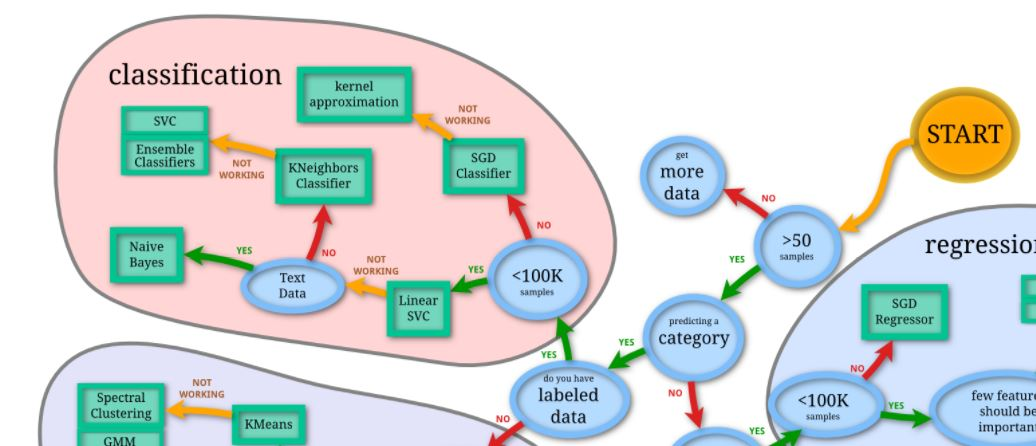

In [8]:
from IPython.display import Image, display
display(Image(filename='sklearn-algos.jpg', embed=True))

(Imagem no domínio público CC0, originalmente em http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).


## 7. Execução da Classificação

Uma vez definido qual o algoritmo de classificação a ser utilizado e com os dados já divididos em base de treinamento e teste, foi executado o script abaixo para efetuar a classificação e medir a eficiência do algoritmo.

In [9]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

# Para reformatar coordenadas.
def changeCoord(x):
    x = x.strip('()')
    return x.split(";")

#Efetua leitura do arquivo csv.
def read_csv():
    "Leitura das colunas: nome do arquivo, rótulo, 56 colunas de coordenadas."
    all_cols = list(range(0,65))
    remove_cols = set(range(2,9))
    cols = [col for col in all_cols if col not in remove_cols]
    return pd.read_csv('Faces_Disciplina\imagedb_CH_disciplina.csv', header=None, usecols=cols)

df = read_csv()

# Renomeia colunas
new_cols = []
new_cols.append('file_name')
new_cols.append('label')
for i in range(1, len(df.columns)-1):
    new_cols.append('p' + str(i))
df.columns = new_cols

# Faz o split das coordenadas, substituindo o formato (x1;y1) por x1 y1
for col in df.columns[2:]:
    s = df[col].apply(changeCoord)
    df['x'+col[1:]] = s.apply(lambda x: x[0])
    df['y'+col[1:]] = s.apply(lambda x: x[1])
    del df[col]

df = df.loc[df['label'].isin(['neutral', 'joy', 'anger', 'fear', 'sadness'])]
    
class_score = []
for i in range(0, 20):
    # Divisão do dataset em treinamento (80%) e validação (20%)
    msk = np.random.rand(len(df)) < 0.80
    training = df[msk]
    testing = df[~msk]

    # Seleciona sub-arrays e prepara para uso na sklearn
    training_set = training.loc[:,'x1':].as_matrix()
    training_lbls = training['label'].as_matrix()
    testing_set = testing.loc[:,'x1':].as_matrix()
    testing_lbls = testing['label'].as_matrix()
    classifier = SVC(kernel='linear')
    classifier.fit(training_set, training_lbls)

    # Retorna o score da classificação em relação aos rótulos.
    score = classifier.score(testing_set, testing_lbls)
    class_score.append(score)
    print("#{0:2} Score = {1:.2f}".format(i+1, score))

print(("Média de acurácia depois de 20 execuções: {0:.2f}".format(np.mean(class_score))))

# 1 Score = 0.96
# 2 Score = 0.88
# 3 Score = 0.78
# 4 Score = 0.95
# 5 Score = 0.91
# 6 Score = 0.93
# 7 Score = 0.92
# 8 Score = 0.95
# 9 Score = 0.89
#10 Score = 0.88
#11 Score = 0.94
#12 Score = 1.00
#13 Score = 0.95
#14 Score = 0.90
#15 Score = 0.98
#16 Score = 0.94
#17 Score = 0.90
#18 Score = 0.86
#19 Score = 0.97
#20 Score = 0.91
Média de acurácia depois de 20 execuções: 0.92


Notei que a performance do algoritmo, após executar múltiplas vezes, obteve uma acurácia média de 89%.

## 8. Análise e manipulação de features

Para procurar melhorar a performance do classificador, uma primeira idéia a ser implementada no código foi fazer o "scaling" das coordenadas dos marcos faciais, para manter as features na faixa numérica de 0 a 1. A justificativa para esse processo é tentar evitar que features de valor alto dominem na classificação. A biblioteca scikitlearn provê vários escalonadores que facilitam a tarefa.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[df_scaled.columns[2:]] = scaler.fit_transform(df_scaled[df_scaled.columns[2:]])

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 10)

df_scaled

,file_name,label,x1,y1,x2,...,y54,x55,y55,x56,y56
39,Em22_Fala1_0049_640x480.png,anger,0.275862,0.768519,0.426667,...,1,0.486111,0.740741,0.445946,0.967742
...,...,...,...,...,...,...,...,...,...,...,...
818,Em12_Fala3_0058_640x480.png,sadness,0.310345,0.583333,0.36,...,0.386364,0.291667,0.62037,0.310811,0.443548


Uma segunda oportunidade foi a adição de features derivados dos marcos faciais. Para preservar a movimentação do rosto, ao invés de usar coordenadas absolutas dos marcos faciais, foi implementado código para encontrar um centro geométrico dos marcos através da obtenção da média das coordenadas em x ou y. 

A partir das médias, foram criadas novas features obtendo a distância dos marcos originais em relação às médias. 

In [11]:
# Execução com marcos relativos.
df_relative = df.copy()
df_relative.iloc[:,2::] = df_relative.iloc[:,2::].apply(pd.to_numeric, errors='coerce')

# Seleciona colunas com coordenadas x e calcula a média por linha (de uma mesma amostra)
dfX = df_relative.iloc[:,range(2,len(df_relative.columns),2)]
dfX = dfX.apply(pd.to_numeric, errors='coerce')
dfX['meanX'] = dfX.mean(axis=1)

# Seleciona colunas com coordenadas y e calcula a média por linha (de uma mesma amostra)
dfY = df_relative.iloc[:,range(2,len(df_relative.columns),2)]
dfY = dfY.apply(pd.to_numeric, errors='coerce')
dfY['meanY'] = dfY.mean(axis=1)

# Ajuste das features baseadas em marcos relativos em relação a um ponto central na face.
for col in df_relative.columns[2::2]:
    df_relative[col] = abs(df_relative[col] - dfX['meanX'])

for col in df_relative.columns[3::2]:
    df_relative[col] = abs(df_relative[col] - dfY['meanY'])

# Adicione novas colunas ao fim do dataframe original
for col in df_relative.columns[2:]:
    df[col+'r'] = df_relative[col]
    
pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 10)

df

,file_name,label,x1,y1,x2,...,y54r,x55r,y55r,x56r,y56r
39,Em22_Fala1_0049_640x480.png,anger,302.0,328.0,370.5,...,17.0446,18.5446,17.9554,16.5446,10.0446
...,...,...,...,...,...,...,...,...,...,...,...
818,Em12_Fala3_0058_640x480.png,sadness,303.5,318.0,368.0,...,21.2857,13.7143,22.2857,13.7143,20.2857


### Execução da classificação final

Após gerar as novas features, foi executado mais uma vez o código para comparar a performance do algoritmo SVM com as duas alterações.

In [13]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Para reformatar coordenadas.
def changeCoord(x):
    x = x.strip('()')
    return x.split(";")

#Efetua leitura do arquivo csv.
def read_csv():
    "Leitura das colunas: nome do arquivo, rótulo, 56 colunas de coordenadas."
    all_cols = list(range(0,65))
    remove_cols = set(range(2,9))
    cols = [col for col in all_cols if col not in remove_cols]
    return pd.read_csv('Faces_Disciplina\imagedb_CH_disciplina.csv', header=None, usecols=cols)

def classify(df):
    # Divisão do dataset em treinamento (80%) e validação (20%)
    msk = np.random.rand(len(df)) < 0.80
    training = df[msk]
    testing = df[~msk]

    # Seleciona sub-arrays e prepara para uso na sklearn
    training_set = training.loc[:,'x1':].as_matrix()
    training_lbls = training['label'].as_matrix()
    testing_set = testing.loc[:,'x1':].as_matrix()
    testing_lbls = testing['label'].as_matrix()
    classifier = SVC(kernel='linear')
    
    classifier.fit(training_set, training_lbls)

    # Retorna o score da classificação em relação aos rótulos.
    lbl_pred = classifier.predict(testing_set)
    print(classification_report(testing_lbls, lbl_pred))
        
    score = classifier.score(testing_set, testing_lbls)

    return score

# Leitura e preparação do data set
df = read_csv()
# Renomeia colunas
new_cols = []
new_cols.append('file_name')
new_cols.append('label')
for i in range(1, len(df.columns)-1):
    new_cols.append('p' + str(i))
df.columns = new_cols
# Faz o split das coordenadas, substituindo o formato (x1;y1) por x1 y1
for col in df.columns[2:]:
    s = df[col].apply(changeCoord)
    df['x'+col[1:]] = s.apply(lambda x: x[0])
    df['y'+col[1:]] = s.apply(lambda x: x[1])
    del df[col]

# Restrição das classes
df = df.loc[df['label'].isin(['neutral', 'joy', 'anger', 'fear', 'sadness'])]

# Executa classificação.
print("Classificação inicial:")
score = classify(df)
print(("Acurácia (sem scaling): {0:.2f}".format(score)))

# Execução com scaling de features
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[df_scaled.columns[2:]] = scaler.fit_transform(df_scaled[df_scaled.columns[2:]])
print("Classificação com scaling:")
score = classify(df_scaled)
print(("Acurácia (com scaling): {0:.2f}".format(score)))

# Execução com marcos relativos.
df_relative = df.copy()
df_relative.iloc[:,2::] = df_relative.iloc[:,2::].apply(pd.to_numeric, errors='coerce')

# Seleciona colunas com coordenadas x e calcula a média por linha (de uma mesma amostra)
dfX = df_relative.iloc[:,range(2,len(df_relative.columns),2)]
dfX = dfX.apply(pd.to_numeric, errors='coerce')
dfX['meanX'] = dfX.mean(axis=1)

# Seleciona colunas com coordenadas y e calcula a média por linha (de uma mesma amostra)
dfY = df_relative.iloc[:,range(2,len(df_relative.columns),2)]
dfY = dfY.apply(pd.to_numeric, errors='coerce')
dfY['meanY'] = dfY.mean(axis=1)

# Ajuste das features baseadas em marcos relativos em relação a um ponto central na face.
for col in df_relative.columns[2::2]:
    df_relative[col] = (df_relative[col] - dfX['meanX'])

for col in df_relative.columns[3::2]:
    df_relative[col] = (df_relative[col] - dfY['meanY'])

# Adicione novas colunas ao fim do dataframe original
for col in df_relative.columns[2:]:
    df[col+'r'] = df_relative[col]

print("Classificação com marcos relativos:")
score = classify(df)
print(("Acurácia (com marcos relativos): {0:.2f}".format(score)))

Classificação inicial:
             precision    recall  f1-score   support

      anger       0.86      1.00      0.92         6
       fear       0.80      1.00      0.89         4
        joy       1.00      1.00      1.00         5
    neutral       1.00      0.78      0.88         9
    sadness       0.83      0.83      0.83         6

avg / total       0.91      0.90      0.90        30

Acurácia (sem scaling): 0.90
Classificação com scaling:
             precision    recall  f1-score   support

      anger       0.92      1.00      0.96        11
       fear       0.86      0.86      0.86         7
        joy       1.00      1.00      1.00         6
    neutral       0.62      1.00      0.77         5
    sadness       1.00      0.64      0.78        11

avg / total       0.91      0.88      0.87        40

Acurácia (com scaling): 0.88
Classificação com marcos relativos:
             precision    recall  f1-score   support

      anger       0.86      1.00      0.92         6
 

## 9. Discussão dos Resultados

- A performance do algoritmo não foi modificada de forma significativa após a alteração e/ou adição de novas features. Provavelmente isso se deve ao fato que as features iniciais do problema (marcos faciais) já contém informação suficiente para o algoritmo classificador.
- Analisando a base de dados, pode-se verificar que a quantidade de rótulos emocionais originais é muito extensa, com 23 classes. Após reduzirmos a quantidade de rótulos para 5, a performance na faixa de 90% se explica pelo fato que a quantidade de hiper-planos que o algoritmo precisa lidar é pequena. Com a base original, a performance é bem menor, na casa de 60-70%.
- O volume de amostras fornecida foi baixo (cerca de 200 amostras com redução das classes) e por causa disso a performance encontrada foi alta.

## Referências

- Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- Smola, Alex J., and Bernhard Schölkopf. "A tutorial on support vector regression." Statistics and computing 14, no. 3 (2004): 199-222.